In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [2]:
with open('data/processed_corpus.json',encoding="utf-8") as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [4]:
for text in corpus[:5]:
    print(' '.join(text))

пытаться реализовать свой человек гораздо низка цена возложить обязанность доплачивать разница
никакой переговоры снижение ставка адекватный уровень привести успех
офис тверская ямский благополучно провести операция это последний платёж
паспорт проверить несколько человек машинка позвонить служба безопасность действительно это хотеть снять
сожаление последний год мнение банка измениться отрицательный сторона


# CBOW

In [5]:
sample_text = corpus[1]

In [6]:
' '.join(sample_text)

'никакой переговоры снижение ставка адекватный уровень привести успех'

# Реализуйте разделение предложения на примеры методом CBOW

In [7]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    window+=1
    
    last = len(tokens) - 1
    for i, word in enumerate(tokens):        
        left_context = []
        right_context = []
        for x in range(1, window):
            left = i - x
            right = i + x
            left_context.insert(0, pad_token if left < 0 else tokens[left])             
            right_context.append(pad_token if right > last else tokens[right])                
        splits.append([left_context, word, right_context])
        
    return splits

In [8]:
splits = cbow_split(sample_text, window=2)
print(splits)

[[['PAD', 'PAD'], 'никакой', ['переговоры', 'снижение']], [['PAD', 'никакой'], 'переговоры', ['снижение', 'ставка']], [['никакой', 'переговоры'], 'снижение', ['ставка', 'адекватный']], [['переговоры', 'снижение'], 'ставка', ['адекватный', 'уровень']], [['снижение', 'ставка'], 'адекватный', ['уровень', 'привести']], [['ставка', 'адекватный'], 'уровень', ['привести', 'успех']], [['адекватный', 'уровень'], 'привести', ['успех', 'PAD']], [['уровень', 'привести'], 'успех', ['PAD', 'PAD']]]


In [9]:
sample_text

['никакой',
 'переговоры',
 'снижение',
 'ставка',
 'адекватный',
 'уровень',
 'привести',
 'успех']

In [10]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: никакой
Правый контекст: ['переговоры', 'снижение']

Левый контекст: ['PAD', 'никакой']
Центральное слово: переговоры
Правый контекст: ['снижение', 'ставка']

Левый контекст: ['никакой', 'переговоры']
Центральное слово: снижение
Правый контекст: ['ставка', 'адекватный']

Левый контекст: ['переговоры', 'снижение']
Центральное слово: ставка
Правый контекст: ['адекватный', 'уровень']

Левый контекст: ['снижение', 'ставка']
Центральное слово: адекватный
Правый контекст: ['уровень', 'привести']

Левый контекст: ['ставка', 'адекватный']
Центральное слово: уровень
Правый контекст: ['привести', 'успех']

Левый контекст: ['адекватный', 'уровень']
Центральное слово: привести
Правый контекст: ['успех', 'PAD']

Левый контекст: ['уровень', 'привести']
Центральное слово: успех
Правый контекст: ['PAD', 'PAD']



In [11]:
splits

[[['PAD', 'PAD'], 'никакой', ['переговоры', 'снижение']],
 [['PAD', 'никакой'], 'переговоры', ['снижение', 'ставка']],
 [['никакой', 'переговоры'], 'снижение', ['ставка', 'адекватный']],
 [['переговоры', 'снижение'], 'ставка', ['адекватный', 'уровень']],
 [['снижение', 'ставка'], 'адекватный', ['уровень', 'привести']],
 [['ставка', 'адекватный'], 'уровень', ['привести', 'успех']],
 [['адекватный', 'уровень'], 'привести', ['успех', 'PAD']],
 [['уровень', 'привести'], 'успех', ['PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [12]:
cbow_split(sample_text, window=3)

[[['PAD', 'PAD', 'PAD'], 'никакой', ['переговоры', 'снижение', 'ставка']],
 [['PAD', 'PAD', 'никакой'],
  'переговоры',
  ['снижение', 'ставка', 'адекватный']],
 [['PAD', 'никакой', 'переговоры'],
  'снижение',
  ['ставка', 'адекватный', 'уровень']],
 [['никакой', 'переговоры', 'снижение'],
  'ставка',
  ['адекватный', 'уровень', 'привести']],
 [['переговоры', 'снижение', 'ставка'],
  'адекватный',
  ['уровень', 'привести', 'успех']],
 [['снижение', 'ставка', 'адекватный'],
  'уровень',
  ['привести', 'успех', 'PAD']],
 [['ставка', 'адекватный', 'уровень'], 'привести', ['успех', 'PAD', 'PAD']],
 [['адекватный', 'уровень', 'привести'], 'успех', ['PAD', 'PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [13]:
' '.join(sample_text)

'никакой переговоры снижение ставка адекватный уровень привести успех'

# Реализуйте разделение предложения на примеры методом Skipgram

In [14]:
sample_text

['никакой',
 'переговоры',
 'снижение',
 'ставка',
 'адекватный',
 'уровень',
 'привести',
 'успех']

In [15]:
def skipgram_split(tokens, window):
    
    splits = []
        
    window+=1
    
    last = len(tokens) - 1
    for i, word in enumerate(tokens):                 
        for x in range(1, window):
            left = i - x
            right = i + x
            if left > 0:            
                splits.append([word, tokens[left]])
            if right < last:
                splits.append([word, tokens[right]])
            
    return splits

In [16]:
splits = skipgram_split(sample_text, window=2)

In [17]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: никакой
Центральное слово: переговоры

Контекст: никакой
Центральное слово: снижение

Контекст: переговоры
Центральное слово: снижение

Контекст: переговоры
Центральное слово: ставка

Контекст: снижение
Центральное слово: переговоры

Контекст: снижение
Центральное слово: ставка

Контекст: снижение
Центральное слово: адекватный

Контекст: ставка
Центральное слово: снижение

Контекст: ставка
Центральное слово: адекватный

Контекст: ставка
Центральное слово: переговоры

Контекст: ставка
Центральное слово: уровень

Контекст: адекватный
Центральное слово: ставка

Контекст: адекватный
Центральное слово: уровень

Контекст: адекватный
Центральное слово: снижение

Контекст: адекватный
Центральное слово: привести

Контекст: уровень
Центральное слово: адекватный

Контекст: уровень
Центральное слово: привести

Контекст: уровень
Центральное слово: ставка

Контекст: привести
Центральное слово: уровень

Контекст: привести
Центральное слово: адекватный

Контекст: успех
Центральное слово: при

In [18]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: никакой
Центральное слово: переговоры

Контекст: никакой
Центральное слово: снижение

Контекст: переговоры
Центральное слово: снижение

Контекст: переговоры
Центральное слово: ставка

Контекст: снижение
Центральное слово: переговоры

Контекст: снижение
Центральное слово: ставка

Контекст: снижение
Центральное слово: адекватный

Контекст: ставка
Центральное слово: снижение

Контекст: ставка
Центральное слово: адекватный

Контекст: ставка
Центральное слово: переговоры

Контекст: ставка
Центральное слово: уровень

Контекст: адекватный
Центральное слово: ставка

Контекст: адекватный
Центральное слово: уровень

Контекст: адекватный
Центральное слово: снижение

Контекст: адекватный
Центральное слово: привести

Контекст: уровень
Центральное слово: адекватный

Контекст: уровень
Центральное слово: привести

Контекст: уровень
Центральное слово: ставка

Контекст: привести
Центральное слово: уровень

Контекст: привести
Центральное слово: адекватный

Контекст: успех
Центральное слово: при

In [19]:
skipgram_split(sample_text, window=2)

[['никакой', 'переговоры'],
 ['никакой', 'снижение'],
 ['переговоры', 'снижение'],
 ['переговоры', 'ставка'],
 ['снижение', 'переговоры'],
 ['снижение', 'ставка'],
 ['снижение', 'адекватный'],
 ['ставка', 'снижение'],
 ['ставка', 'адекватный'],
 ['ставка', 'переговоры'],
 ['ставка', 'уровень'],
 ['адекватный', 'ставка'],
 ['адекватный', 'уровень'],
 ['адекватный', 'снижение'],
 ['адекватный', 'привести'],
 ['уровень', 'адекватный'],
 ['уровень', 'привести'],
 ['уровень', 'ставка'],
 ['привести', 'уровень'],
 ['привести', 'адекватный'],
 ['успех', 'привести'],
 ['успех', 'уровень']]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [20]:
skipgram_split(sample_text, window=3)

[['никакой', 'переговоры'],
 ['никакой', 'снижение'],
 ['никакой', 'ставка'],
 ['переговоры', 'снижение'],
 ['переговоры', 'ставка'],
 ['переговоры', 'адекватный'],
 ['снижение', 'переговоры'],
 ['снижение', 'ставка'],
 ['снижение', 'адекватный'],
 ['снижение', 'уровень'],
 ['ставка', 'снижение'],
 ['ставка', 'адекватный'],
 ['ставка', 'переговоры'],
 ['ставка', 'уровень'],
 ['ставка', 'привести'],
 ['адекватный', 'ставка'],
 ['адекватный', 'уровень'],
 ['адекватный', 'снижение'],
 ['адекватный', 'привести'],
 ['адекватный', 'переговоры'],
 ['уровень', 'адекватный'],
 ['уровень', 'привести'],
 ['уровень', 'ставка'],
 ['уровень', 'снижение'],
 ['привести', 'уровень'],
 ['привести', 'адекватный'],
 ['привести', 'ставка'],
 ['успех', 'привести'],
 ['успех', 'уровень'],
 ['успех', 'адекватный']]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [21]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [22]:
# for x, y in word2index.items():
#     print(x, y)

In [23]:
len(word2index)

13115

In [24]:
word2index['UNK']

54

In [25]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[794, 1666, 54]

# Torch Dataset
В торче есть очень удобная читалка данных

In [26]:
from torch.utils.data import Dataset, DataLoader

In [27]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [28]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.80977671, 0.77066475, 0.92476134, 0.47085537],
       [0.40090137, 0.44687768, 0.06388089, 0.8145848 ],
       [0.90599718, 0.83045259, 0.34619412, 0.56373319],
       [0.15726881, 0.7518913 , 0.29952456, 0.04253021],
       [0.94786486, 0.84724041, 0.27208087, 0.57787854],
       [0.15153354, 0.25446286, 0.24585971, 0.49883223],
       [0.45310714, 0.49452822, 0.14217574, 0.85842374],
       [0.66825901, 0.23961578, 0.77254557, 0.98306616],
       [0.66826801, 0.08158746, 0.36103022, 0.79699975],
       [0.82804305, 0.15253947, 0.66743598, 0.5803532 ]])

In [29]:
some_data_y

array([2, 0, 0, ..., 0, 0, 1])

In [30]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [31]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [32]:
some_dataset[5], some_dataset[467]

((array([0.15153354, 0.25446286, 0.24585971, 0.49883223]), 2),
 (array([0.476599  , 0.24260453, 0.3990134 , 0.09784495]), 1))

In [33]:
some_loader = DataLoader(some_dataset, batch_size=16)

In [34]:
for x, y in some_loader:
    break
    
len(x), x

(16, tensor([[0.8098, 0.7707, 0.9248, 0.4709],
         [0.4009, 0.4469, 0.0639, 0.8146],
         [0.9060, 0.8305, 0.3462, 0.5637],
         [0.1573, 0.7519, 0.2995, 0.0425],
         [0.9479, 0.8472, 0.2721, 0.5779],
         [0.1515, 0.2545, 0.2459, 0.4988],
         [0.4531, 0.4945, 0.1422, 0.8584],
         [0.6683, 0.2396, 0.7725, 0.9831],
         [0.6683, 0.0816, 0.3610, 0.7970],
         [0.8280, 0.1525, 0.6674, 0.5804],
         [0.8913, 0.8069, 0.4342, 0.6978],
         [0.8670, 0.4676, 0.4188, 0.8472],
         [0.6538, 0.3527, 0.9353, 0.2663],
         [0.6468, 0.6994, 0.3325, 0.9031],
         [0.3518, 0.4764, 0.5470, 0.8812],
         [0.1693, 0.0083, 0.1573, 0.3352]], dtype=torch.float64))

In [35]:
for x, y in some_loader:
    pass

len(x)

15

In [36]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [37]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [38]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [39]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [40]:
for x, y in toy_loader:
    break

In [41]:
x.shape

torch.Size([128, 32])

In [42]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.8098,   0.7707,   0.9248,  ...,  -1.5630,  -0.4693,  -4.5192],
        [  0.4009,   0.4469,   0.0639,  ...,  -4.8328, -16.5044,  -1.2305],
        [  0.9060,   0.8305,   0.3462,  ...,  -1.1147,  -6.3645,  -3.4390],
        ...,
        [  0.4155,   0.1297,   0.4861,  ..., -12.2536,  -4.3281,  -0.4807],
        [  0.6562,   0.4834,   0.7178,  ...,  -4.3619,  -1.9895, -17.6333],
        [  0.1936,   0.5430,   0.5879,  ...,  -3.6640,  -3.1874,  -4.4416]],
       dtype=torch.float64)

In [43]:
y

tensor([2, 0, 0, 0, 1, 2, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2,
        0, 0, 1, 2, 0, 1, 1, 1, 2, 0, 1, 2, 1, 2, 0, 2, 1, 0, 1, 1, 2, 0, 1, 0,
        1, 2, 0, 2, 1, 1, 2, 1, 2, 0, 1, 2, 0, 1, 1, 1, 2, 0, 1, 0, 2, 1, 1, 2,
        0, 0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1,
        2, 0, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2,
        2, 1, 1, 0, 0, 0, 1, 1], dtype=torch.int32)

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [44]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [45]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y.long())
    
loss.item()

1.168760061264038

# Боевые датасеты

In [46]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [47]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose        

        self.data = []

        self.collect_data()
                
    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE
        
        # вставить здесь функцию, которую вы писали раньше

        splits = skipgram_split(tokenized_text, window=self.window)

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)
            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE        
        
#         print(self.data[idx], idx, "of", len(self.data))

        context, central_word = self.data[idx]
        
#         context = torch.Tensor(context).long()

        return context, central_word

In [48]:
dataset = SkipgramDataset(corpus, word2index)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 21042.57it/s]


In [49]:
BATCH_SIZE = 512

In [50]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [51]:
for x, y in dataset_loader:
    print(x,y)
    break

tensor([  244,   819,    60,    66,   840,   320,   132,    61,     3,   770,
          269,  1043,    63,  9323,   402,   668,   323,  2300,   402,   730,
         7510,   279,    54,    19,   813,   659,  4283,   561,    61,   644,
           61,   403,    54,    34,   650,  1340,    62,  1061,   772,  7031,
          199,   974,   415,  1281,  5857,  3345,   151,  2282,    66,   286,
          305,   860,   622,   806,   402,   748,   836,    53,  1099,   237,
          124,  1033,    46,   861,   151,     2,   230,    11,  7230,  3303,
          946,   441,   299,   131,   440,    41,    53,   674,  1167,   987,
         2237,  1126,  2126,   320,    41,    88,    87,    37,  1166,   265,
           60,   242,    82,   853,   915,    38,   230,   197,    53,    87,
          143,   272,    54,  3004,  2277,   927,  1054,  1082,    67,    60,
           19,  2605,   919,  5239,  2789,  4469,   439,   345,   696,   889,
         1698,   555,   203,   250,   796,  2727,   309,  1330, 

In [52]:
x[:5]

tensor([244, 819,  60,  66, 840])

In [53]:
y[:5]

tensor([  41, 2486, 5408, 1420, 2235])

In [54]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [55]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [56]:
# CODE
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim, out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

In [57]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [58]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [59]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([13115])

In [60]:
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [61]:
# epochs = 3
epochs = 5

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # CODE
            x = x.view(x.shape[0], -1)
       
            optimizer.zero_grad()
        
            pred = model(x)
        
            loss = criterion(pred, y.long())
            
            loss.backward()
        
            optimizer.step()
            
            # CODE
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 2:  63%|███████████████████████████████▎                  | 1619968/2582078 [24:04<14:17, 1121.54it/s, loss=6.84]


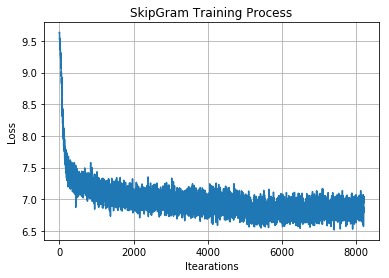

In [62]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [63]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [64]:
embedding_matrix = model.in_embedding.weight.detach()

In [65]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [66]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.8462210893630981

In [67]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.631118893623352

In [68]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.9146569967269897

In [69]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.45749640464782715

In [70]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "затрудниться" равна 0.083'

In [71]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [72]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [73]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13115 samples in 0.050s...
[t-SNE] Computed neighbors for 13115 samples in 15.635s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13115
[t-SNE] Computed conditional probabilities for sample 2000 / 13115
[t-SNE] Computed conditional probabilities for sample 3000 / 13115
[t-SNE] Computed conditional probabilities for sample 4000 / 13115
[t-SNE] Computed conditional probabilities for sample 5000 / 13115
[t-SNE] Computed conditional probabilities for sample 6000 / 13115
[t-SNE] Computed conditional probabilities for sample 7000 / 13115
[t-SNE] Computed conditional probabilities for sample 8000 / 13115
[t-SNE] Computed conditional probabilities for sample 9000 / 13115
[t-SNE] Computed conditional probabilities for sample 10000 / 13115
[t-SNE] Computed conditional probabilities for sample 11000 / 13115
[t-SNE] Computed conditional probabilities for sample 12000 / 13115
[t-SNE] Computed conditional probabilities for sa

In [74]:
top_words = [a for a,_ in top_sorted_freq]

In [75]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

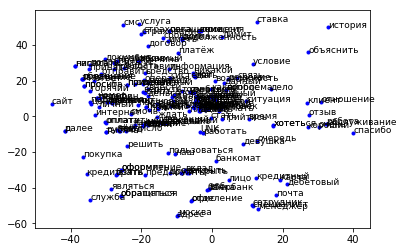

In [76]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()